In [0]:
from pulp import *
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#!{sys.executable} -m pip install xlrd

# Importing the dataset

In [0]:
df = pd.read_excel("openfoodfacts_simplified_database.xlsx")
df = df[~df['nutrition_grade_fr'].isna()]
df['nutrition_grade_fr'].describe()

count     5925
unique       5
top          d
freq      1599
Name: nutrition_grade_fr, dtype: object

In [0]:
# Sample
df = df.sample(frac=0.05)

In [0]:
for col in df.columns:
    print(col)

product_name
brands
categories              
stores
countries
allergens
additives_n
additives_tags
nutrition_grade_fr
nova_group
pnns_groups_1
pnns_groups_2
energy_100g
saturated-fat_100g
sugars_100g
fiber_100g
proteins_100g
sodium_100g
nutrition-score-fr_100g
nutrition-score-uk_100g


In [0]:
cols = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'nutrition_grade_fr']
df = df[cols]
df.columns = ['energy', 'saturated_fat', 'sugars', 'fiber', 'proteins', 'salt', 'nutriscore']
df.head()

,energy,saturated_fat,sugars,fiber,proteins,salt,nutriscore
6362,200.0,0.0,2.6,3.7,2.7,0.200,a
1727,1109.0,2.2,6.4,NaN,0.8,0.960,d
9587,297.0,0.0,16.0,0.1,0.2,0.012,e
3955,1962.0,16.1,19.9,NaN,4.4,0.224,e
6638,1546.0,5.6,15.0,2.1,7.0,0.376,d


In [0]:
df = df[~df['energy'].isna()]
df = df[~df['saturated_fat'].isna()]
df = df[~df['sugars'].isna()]
df = df[~df['fiber'].isna()]
df = df[~df['proteins'].isna()]
df = df[~df['salt'].isna()]

In [0]:
def create_buckets(df, criterion, precision, eps):
    num_buckets = int((df[criterion].max() + eps - df[criterion].min()) / precision)
    max_value = df[criterion].max() + eps
    min_value = df[criterion].min()
    real_precision = (max_value - min_value) / num_buckets
    
    buckets = []
    left_thresh = min_value
    for i in range(num_buckets):
        buckets.append((left_thresh, left_thresh+real_precision))
        left_thresh = left_thresh+real_precision

    return buckets

In [0]:
buckets = {}

43


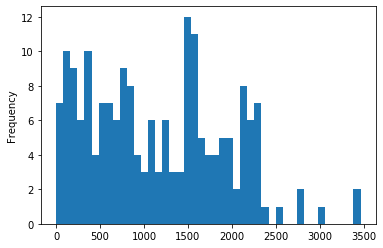

In [0]:
bins = int((df['energy'].max() - df['energy'].min()) / 80)
print(bins)
df['energy'].plot.hist(bins=bins)

27


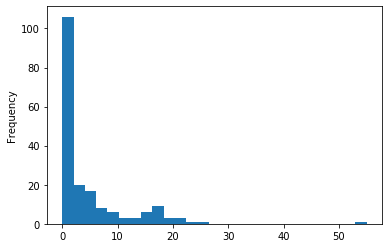

In [0]:
bins = int((df['saturated_fat'].max() - df['saturated_fat'].min()) / 2)
print(bins)
df['saturated_fat'].plot.hist(bins=bins)

64


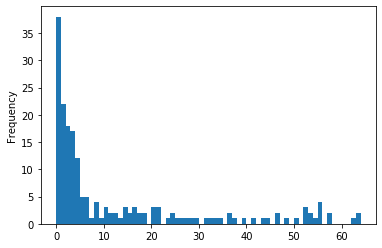

In [0]:
bins = int((df['sugars'].max() - df['sugars'].min()) / 1)
print(bins)
df['sugars'].plot.hist(bins=bins)

33


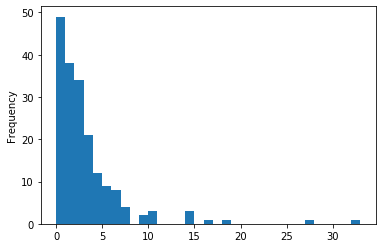

In [0]:
bins = int((df['fiber'].max() - df['fiber'].min()) / 1)
print(bins)
df['fiber'].plot.hist(bins=bins)

40


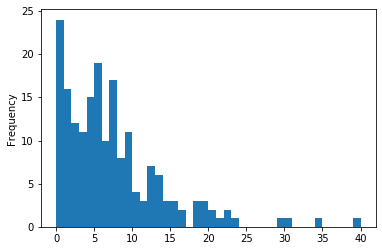

In [0]:
bins = int((df['proteins'].max() - df['proteins'].min()) / 1)
print(bins)
df['proteins'].plot.hist(bins=bins)

4


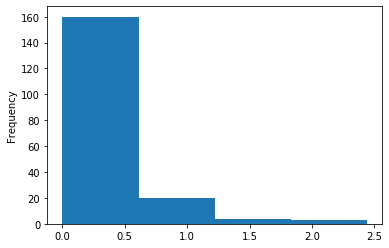

In [0]:
bins = int((df['salt'].max() - df['salt'].min()) / 0.5)
print(bins)
df['salt'].plot.hist(bins=bins)

# Create the buckets

In [0]:
buckets['energy'] = create_buckets(df, 'energy', precision=80, eps=10)
buckets['saturated_fat'] = create_buckets(df, 'saturated_fat', precision=2, eps=0.1)
buckets['sugars'] = create_buckets(df, 'sugars', precision=1, eps=0.1)
buckets['fiber'] = create_buckets(df, 'fiber', precision=1, eps=0.1)
buckets['proteins'] = create_buckets(df, 'proteins', precision=1, eps=0.1)
buckets['salt'] = create_buckets(df, 'salt', precision=0.5, eps=0.05)

# Formalize the problem

In [0]:
prob = LpProblem("The Nutriscore", LpMaximize)

In [0]:
# Variables measuring differences between two consecutives classes
epsilon = []
epsilon.append(LpVariable("epsilon_1",1, 20))
epsilon.append(LpVariable("epsilon_2",1, 20))
epsilon.append(LpVariable("epsilon_3",1, 20))
epsilon.append(LpVariable("epsilon_4",1, 20))

In [0]:
# The objective function is added to 'prob' first
prob += (epsilon[0]+epsilon[1]+epsilon[2]+epsilon[3]), "slack variables (differences between two consecutive classes) to be maximized"

In [0]:
utility_thresh = {}
for key in buckets:
    utility_thresh[key] = []
    
for key in buckets:    
    for i in range(len(buckets[key])):
        utility_thresh[key].append(LpVariable(key+"_"+str(i), 0, 1))
    utility_thresh[key].append(LpVariable(key+"_"+str(len(buckets[key])), 0, 1))

In [0]:
def get_bucket_index(value, buckets):
    return get_bucket_index_r(value, buckets, 0, len(buckets)-1)

In [0]:
def get_bucket_index_r(value, buckets, left, right):
    middle = int((right - left) / 2 + left)
    if (value >= buckets[middle][0]) and (value < buckets[middle][1]):
        return middle
    if value < buckets[middle][0]:
        return get_bucket_index_r(value, buckets, left, middle-1)
    return get_bucket_index_r(value, buckets, middle+1, right)

In [0]:
def utility_func(df, food_index):
    food = df.loc[food_index]
    criteria = list(food.keys())
    criteria.remove('nutriscore')
    utility = 0
    for criterion in criteria:
        bucket_index = get_bucket_index(food[criterion], buckets[criterion])
        left_thresh = buckets[criterion][bucket_index][0]
        right_thresh = buckets[criterion][bucket_index][1]
        m = (food[criterion] - left_thresh) / (right_thresh - food[criterion])
        left_utility = utility_thresh[criterion][bucket_index]
        right_utility = utility_thresh[criterion][bucket_index+1]
        
        utility += left_utility + m * (right_utility - left_utility)
    
    return utility

In [0]:
df['nutriscore'] = np.where(df['nutriscore']=='a', 5, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='b', 4, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='c', 3, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='d', 2, df['nutriscore'])
df['nutriscore'] = np.where(df['nutriscore']=='e', 1, df['nutriscore'])

In [0]:
for index, food in df.iterrows():
    utility_food = utility_func(df, index)
    preceding_foods = df[df['nutriscore'] == food['nutriscore']-1]
    for index2, preceding_food in preceding_foods.iterrows():
        utility_prec_food = utility_func(preceding_foods, index2)
        prob += (utility_food >= utility_prec_food + epsilon[food['nutriscore']-2])

In [0]:
prob += utility_thresh['energy'][len(utility_thresh['energy'])-1] == 0
prob += utility_thresh['saturated_fat'][len(utility_thresh['saturated_fat'])-1] == 0
prob += utility_thresh['sugars'][len(utility_thresh['sugars'])-1] == 0
prob += utility_thresh['salt'][len(utility_thresh['salt'])-1] == 0
prob += utility_thresh['proteins'][0] == 0
prob += utility_thresh['fiber'][0] == 0

In [0]:
prob += utility_thresh['energy'][0] + \
        utility_thresh['saturated_fat'][0] + \
        utility_thresh['sugars'][0] + \
        utility_thresh['salt'][0] + \
        utility_thresh['proteins'][len(utility_thresh['proteins'])-1] + \
        utility_thresh['fiber'][len(utility_thresh['fiber'])-1] == 1

In [0]:
for i in range(len(utility_thresh['energy'])-1):
    prob += utility_thresh['energy'][i] >= utility_thresh['energy'][i+1]
for i in range(len(utility_thresh['saturated_fat'])-1):
    prob += utility_thresh['saturated_fat'][i] >= utility_thresh['saturated_fat'][i+1]
for i in range(len(utility_thresh['sugars'])-1):
    prob += utility_thresh['sugars'][i] >= utility_thresh['sugars'][i+1]
for i in range(len(utility_thresh['salt'])-1):
    prob += utility_thresh['salt'][i] >= utility_thresh['salt'][i+1]

for i in range(len(utility_thresh['proteins'])-1):
    prob += utility_thresh['proteins'][i] <= utility_thresh['proteins'][i+1]
for i in range(len(utility_thresh['fiber'])-1):
    prob += utility_thresh['fiber'][i] <= utility_thresh['fiber'][i+1]



In [0]:
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Infeasible


In [0]:
# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    print(v.name, "=", v.varValue)

energy_0 = 0.35034936
energy_1 = 0.7253155
energy_10 = -0.058683653
energy_11 = -0.715395
energy_12 = 0.0
energy_13 = 0.0
energy_14 = -0.054113753
energy_15 = -0.044763792
energy_16 = 0.0011930342
energy_17 = 0.32640927
energy_18 = 0.12996053
energy_19 = 0.51082418
energy_2 = 0.44048632
energy_20 = 0.22499044
energy_21 = 2.1132308
energy_22 = 1.9655589
energy_23 = 1.8075824
energy_24 = 1.8282529
energy_25 = 1.0681373
energy_26 = 0.58380504
energy_27 = -0.093850925
energy_28 = 0.0
energy_29 = 0.0
energy_3 = 1.5403616
energy_30 = 0.0
energy_31 = 0.0
energy_32 = 0.032242784
energy_33 = 0.032242784
energy_34 = 0.0
energy_35 = 0.0
energy_36 = 0.0
energy_37 = 0.0
energy_38 = 0.0
energy_39 = 0.0
energy_4 = 0.0
energy_40 = 0.0
energy_41 = 0.43376093
energy_42 = 0.43376093
energy_43 = 0.0
energy_5 = 0.11890435
energy_6 = 0.2523639
energy_7 = -0.171615
energy_8 = -0.19859309
energy_9 = -0.14705898
epsilon_1 = 1.0
epsilon_2 = 1.0
epsilon_3 = 1.0
epsilon_4 = 1.0
fiber_0 = 0.0
fiber_1 = -0.00424686

In [0]:
print(df.loc[890])
utility_func(df, 890)

KeyError: 890